# Synthetic Datasets + Noise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.stats import beta
from sklearn.model_selection import train_test_split
import shap
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot Functions

In [2]:
plt.rcParams['legend.fontsize'] = 16


def plot_s(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None,
           cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i), fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            ax.grid(False)
        else:
            if vmin is None:
                v_min = np.floor(b[i].min() * 10) / 10
            else:
                v_min = vmin
            if vmax is None:
                v_max = np.ceil(b[i].max() * 10) / 10
            else:
                v_max = vmax
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=v_min, vmax=v_max, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_axis_off()
            ax.tick_params(axis='x', colors=(0, 0, 0, 0))
            ax.tick_params(axis='y', colors=(0, 0, 0, 0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')

In [3]:
def plot_uncertainty(u, k=3, title=None, sub_titles=None, cmap='flare', s_limits=(5, 20), hue='geo_uncertainty',
                     size='shap_abs'):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    sns.set_style("white")

    for i in range(k):
        ax = axes[i]
        data = u[i]
        g = sns.scatterplot(data=data, x='x', y='y', hue=hue, size=size, palette=cmap, sizes=s_limits, legend=False,
                            edgecolor='.7', ax=ax)
        g.set(xlabel='', ylabel='', aspect='equal')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')


In [4]:
def plot_coverage(c, k=3, size=50, title=None, sub_titles=None, colors=None, cmap=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    legend_elements = [Patch(facecolor=colors[0], edgecolor='.7', label='Not Covered'),
                       Patch(facecolor=colors[1], edgecolor='.7', label='Covered')]
    for i in range(k):
        ax = axes[i]
        ax.imshow(c[i].reshape(size, size), cmap=cmap, vmin=0, vmax=1)
        ax.legend(handles=legend_elements, loc='upper right', title='')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')

## Uncertainty Generation

In [5]:
from scipy.stats import multivariate_normal

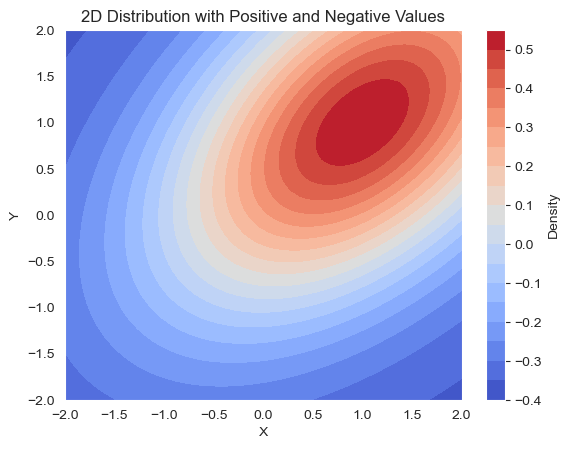

In [6]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
mean = [1, 1]
covariance = [[2, 1], [1, 2]]
rv = multivariate_normal(mean, covariance)
n1 = rv.pdf(pos) * 10
n1 = n1 - n1.mean()

# Plot the distribution
plt.contourf(X, Y, n1, levels=20, cmap='coolwarm')
plt.colorbar(label='Density')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

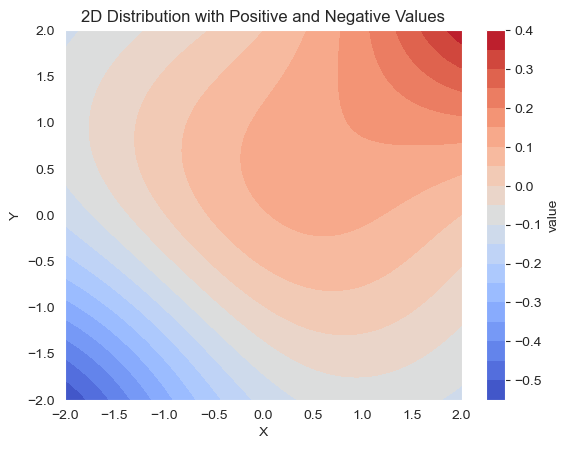

In [7]:
gaussians = [
    multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
    multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
    multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
]

n2 = (gaussians[0] - gaussians[1] + gaussians[2]) * 10
n2 = n2 - n2.mean()

# Plot the distribution
plt.contourf(X, Y, n2, levels=20, cmap='coolwarm')
plt.colorbar(label='value')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Data Generation

In [8]:
size = 50

b1 = np.ones((size, size))
b2 = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b1[i, j] = (i + j) / 49 * 3
        b2[i, j] = 3 * (np.sin(-2 + 4 / 49 * i) * np.cos(-2 + 4 / 49 * j) + 1)


In [9]:
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
n1_ = n1.reshape(-1)
n2_ = n2.reshape(-1)

In [10]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4]).T
u = np.array([np.linspace(0, size - 1, num=size)] * size).reshape(-1)
v = np.array([np.linspace(0, size - 1, num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u, v)))

k = X.shape[1]
n = X.shape[0]

In [11]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1),
                        columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

In [12]:
# f0 = b0
f1 = (b1 + n1_) * X_coords.values[:, 0]
f2 = (b2 + n2_) * X_coords.values[:, 1]
f3 = X_coords.values[:, 2] ** 2
f4 = np.abs(X_coords.values[:, 3]) * 2

In [13]:
y = pd.DataFrame(f1 + f2 + f3 + f4, columns=['y'])

In [14]:
b = [b1, b2, [X_coords.values[:, 2], f3, -1, 5], [X_coords.values[:, 3], f4, -1, 6]]

In [15]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$']

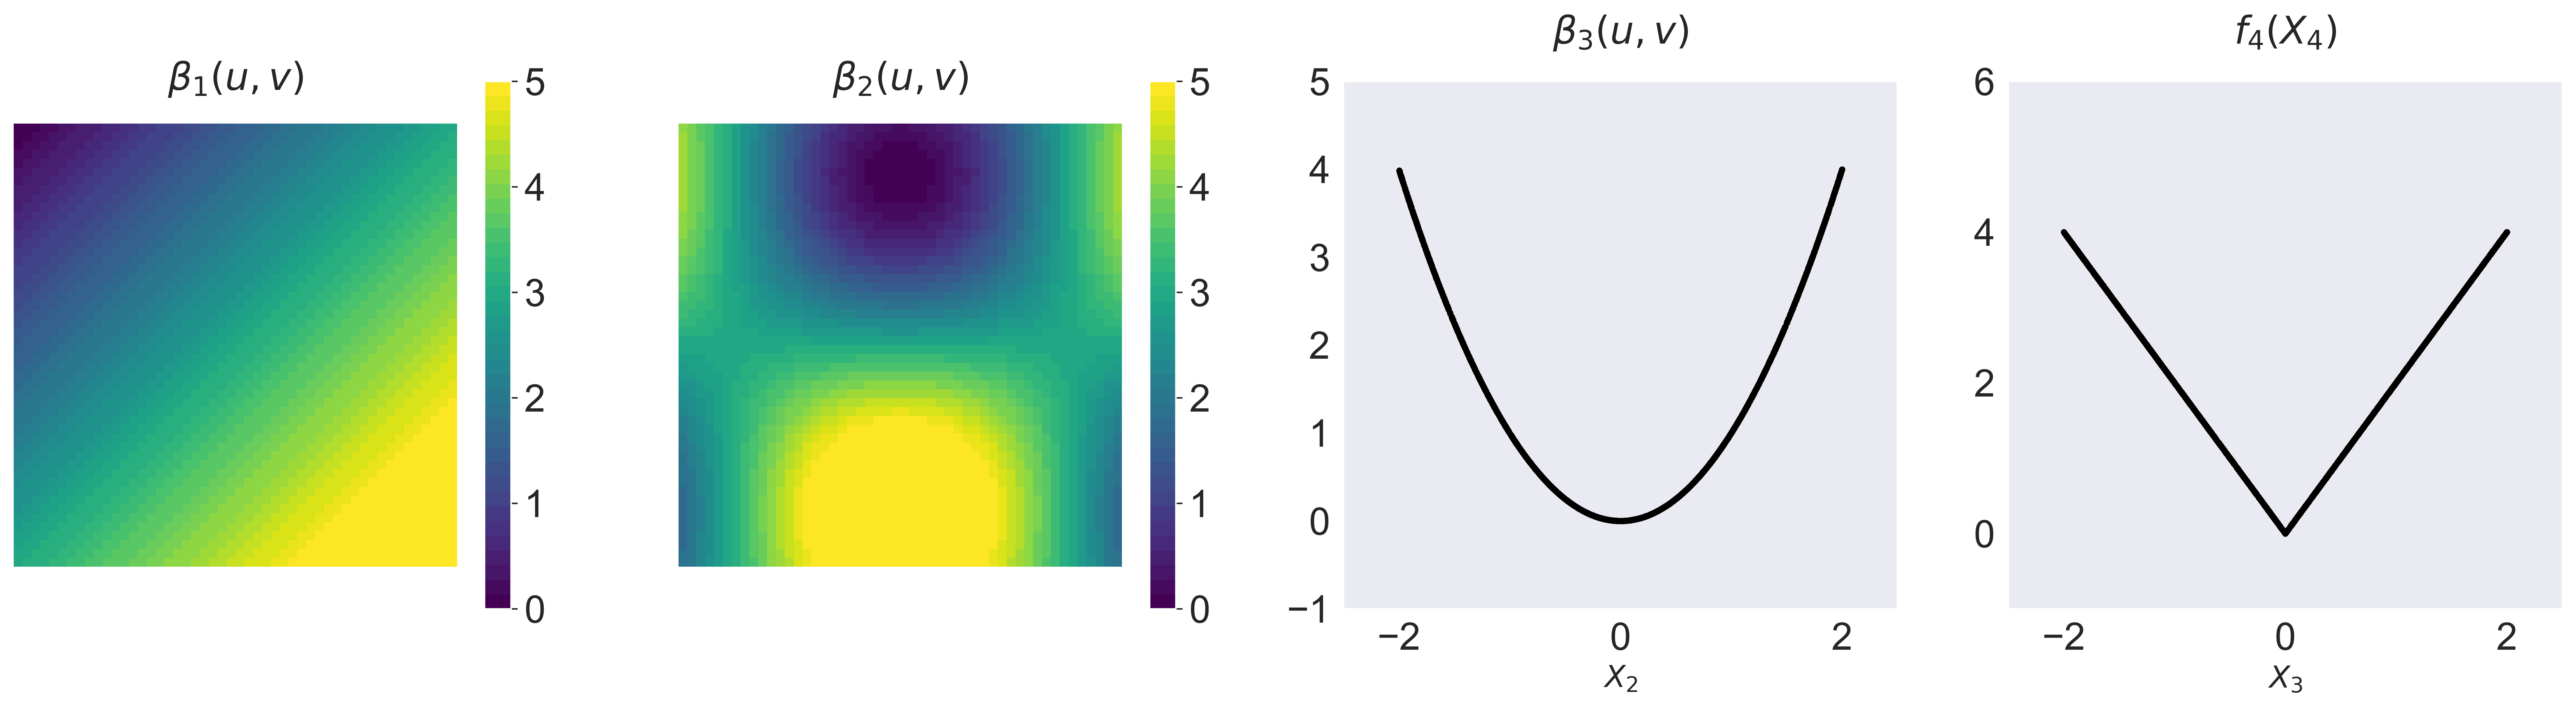

In [16]:
plot_s(b=b, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='TrueModel', non_spatial=[2, 3], size=size)

In [17]:
b_n = [b1 + n1_, b2 + n2_, n1_, n2_]

In [18]:
sub_titles_bn = [r'$\beta_1(u,v) + n_1(u,v)$', r'$\beta_2(u,v) + n_2(u,v)$', r'$n_1$',
                 r'$n_2$']

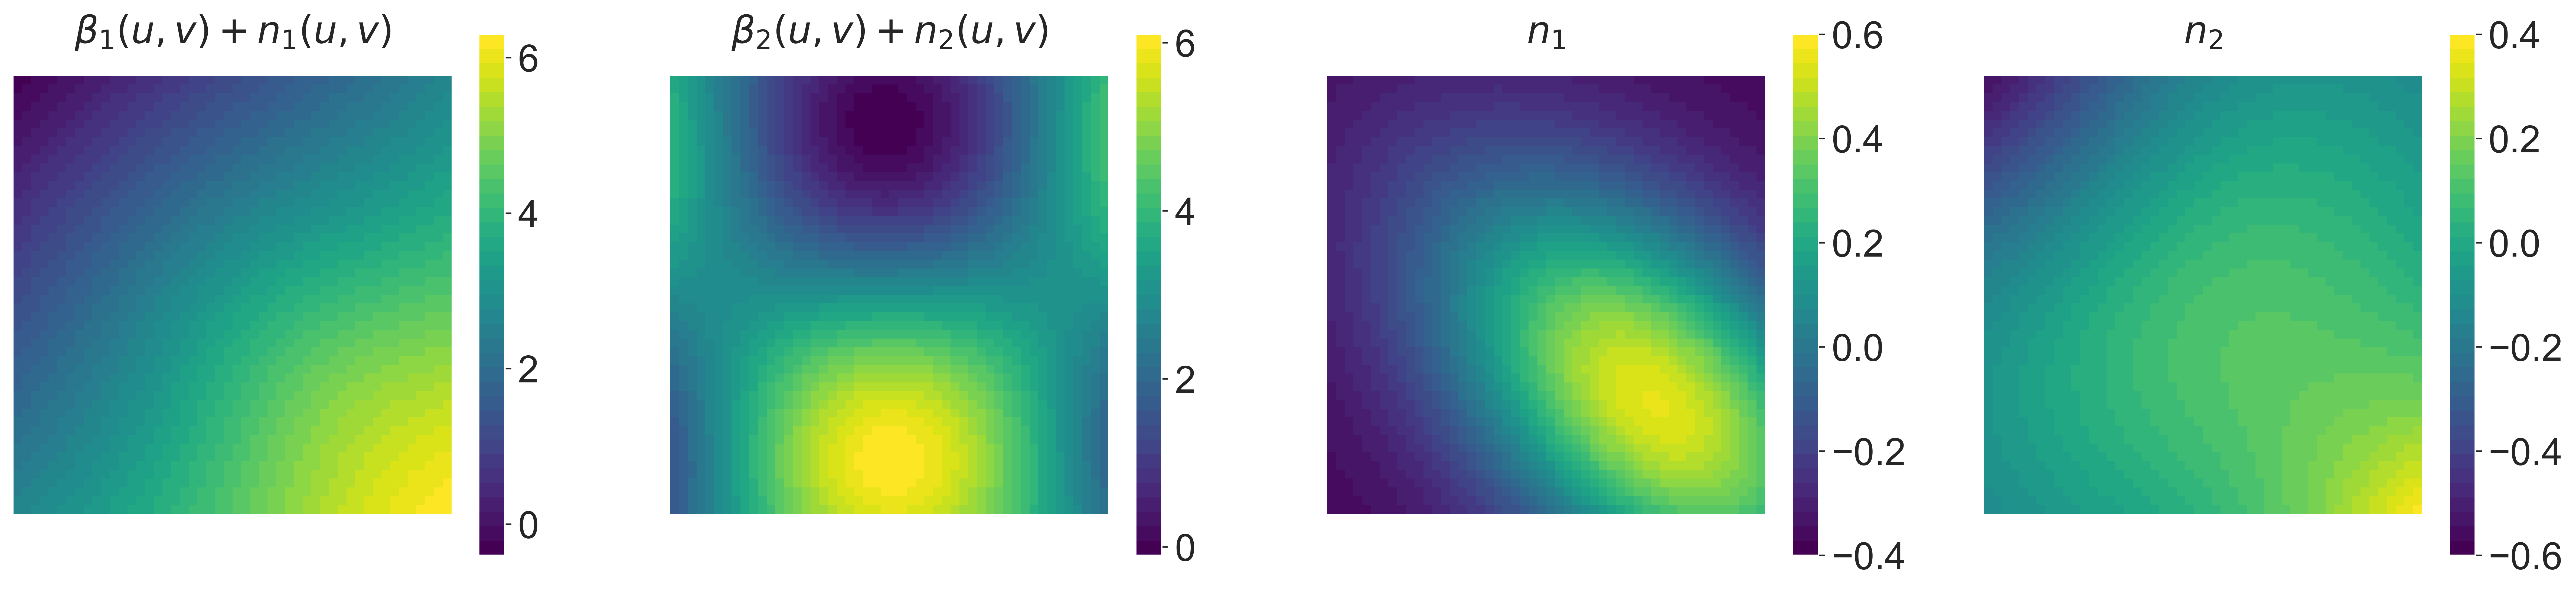

In [19]:
plot_s(b=b_n, k=4, sub_titles=sub_titles_bn, title='TrueModel_with_noise', non_spatial=[], size=size)

In [20]:
loc = X_coords[['x_coord', 'y_coord']]

In [21]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)

In [22]:
def true_model_predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 3
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
    f1 = b_1 * X_coords[:, 0]
    f2 = b_2 * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [23]:
def true_model_predict_with_coeff_noise(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 3
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
    f1 = (b_1 + n1[u, v]) * X_coords[:, 0]
    f2 = (b_2 + n2[u, v]) * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [24]:
def shap_value_f(x):
    explainer_ = shap.Explainer(true_model_predict, x, algorithm='auto')
    return explainer_(x).values

In [25]:
explainer = GeoConformalizedExplainer(prediction_f=true_model_predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=25,
                                      shap_value_f=shap_value_f,
                                      feature_names=X_calib.columns)

In [26]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables


In [27]:
explainer_with_coef_noise = GeoConformalizedExplainer(prediction_f=true_model_predict_with_coeff_noise,
                                                      x_train=X_train,
                                                      x_calib=X_calib,
                                                      coord_calib=loc_calib.values,
                                                      miscoverage_level=0.1,
                                                      band_width=25,
                                                      shap_value_f=shap_value_f,
                                                      feature_names=X_calib.columns)

In [28]:
results_coef_noise = explainer_with_coef_noise.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables


In [29]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
X1,1.0000,0.999191,0.104322,13.452495,13.452212
X2,0.9160,0.941707,0.880664,13.304559,13.624381
X3,0.9044,0.940329,0.290299,1.412315,1.411866
X4,0.8500,0.975273,0.182420,1.345792,1.318575
x_coord,0.9992,0.970828,0.112735,0.435668,0.437124
y_coord,1.0000,0.940854,0.219985,0.818203,0.806185


In [30]:
results_coef_noise.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
X1,1.0000,0.999373,0.091854,13.452495,13.416301
X2,0.8920,0.934954,0.930271,13.304559,13.489814
X3,0.9144,0.937819,0.296343,1.412315,1.407106
X4,0.7596,0.975364,0.182085,1.345792,1.340009
x_coord,0.9992,0.972153,0.110146,0.435668,0.436396
y_coord,1.0000,0.943832,0.214376,0.818203,0.808383


In [31]:
pred_results = results.result_geo

In [32]:
pred_results_coef_noise = results_coef_noise.result_geo

In [33]:
X1_geo_uncertainty = pred_results['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty = pred_results['X2_geo_uncertainty'].values.reshape(-1)

X1_geo_uncertainty_coef_noise = pred_results_coef_noise['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty_coef_noise = pred_results_coef_noise['X2_geo_uncertainty'].values.reshape(-1)

In [34]:
delta_X1 = X1_geo_uncertainty_coef_noise - X1_geo_uncertainty
delta_X2 = X2_geo_uncertainty_coef_noise - X2_geo_uncertainty

In [35]:
geo_uncertainty_list = [delta_X1, delta_X2]
sub_titles_uncertainty = [r'$\delta_{X_1}(u,v)$', r'$\delta_{X_2}(u,v)$']

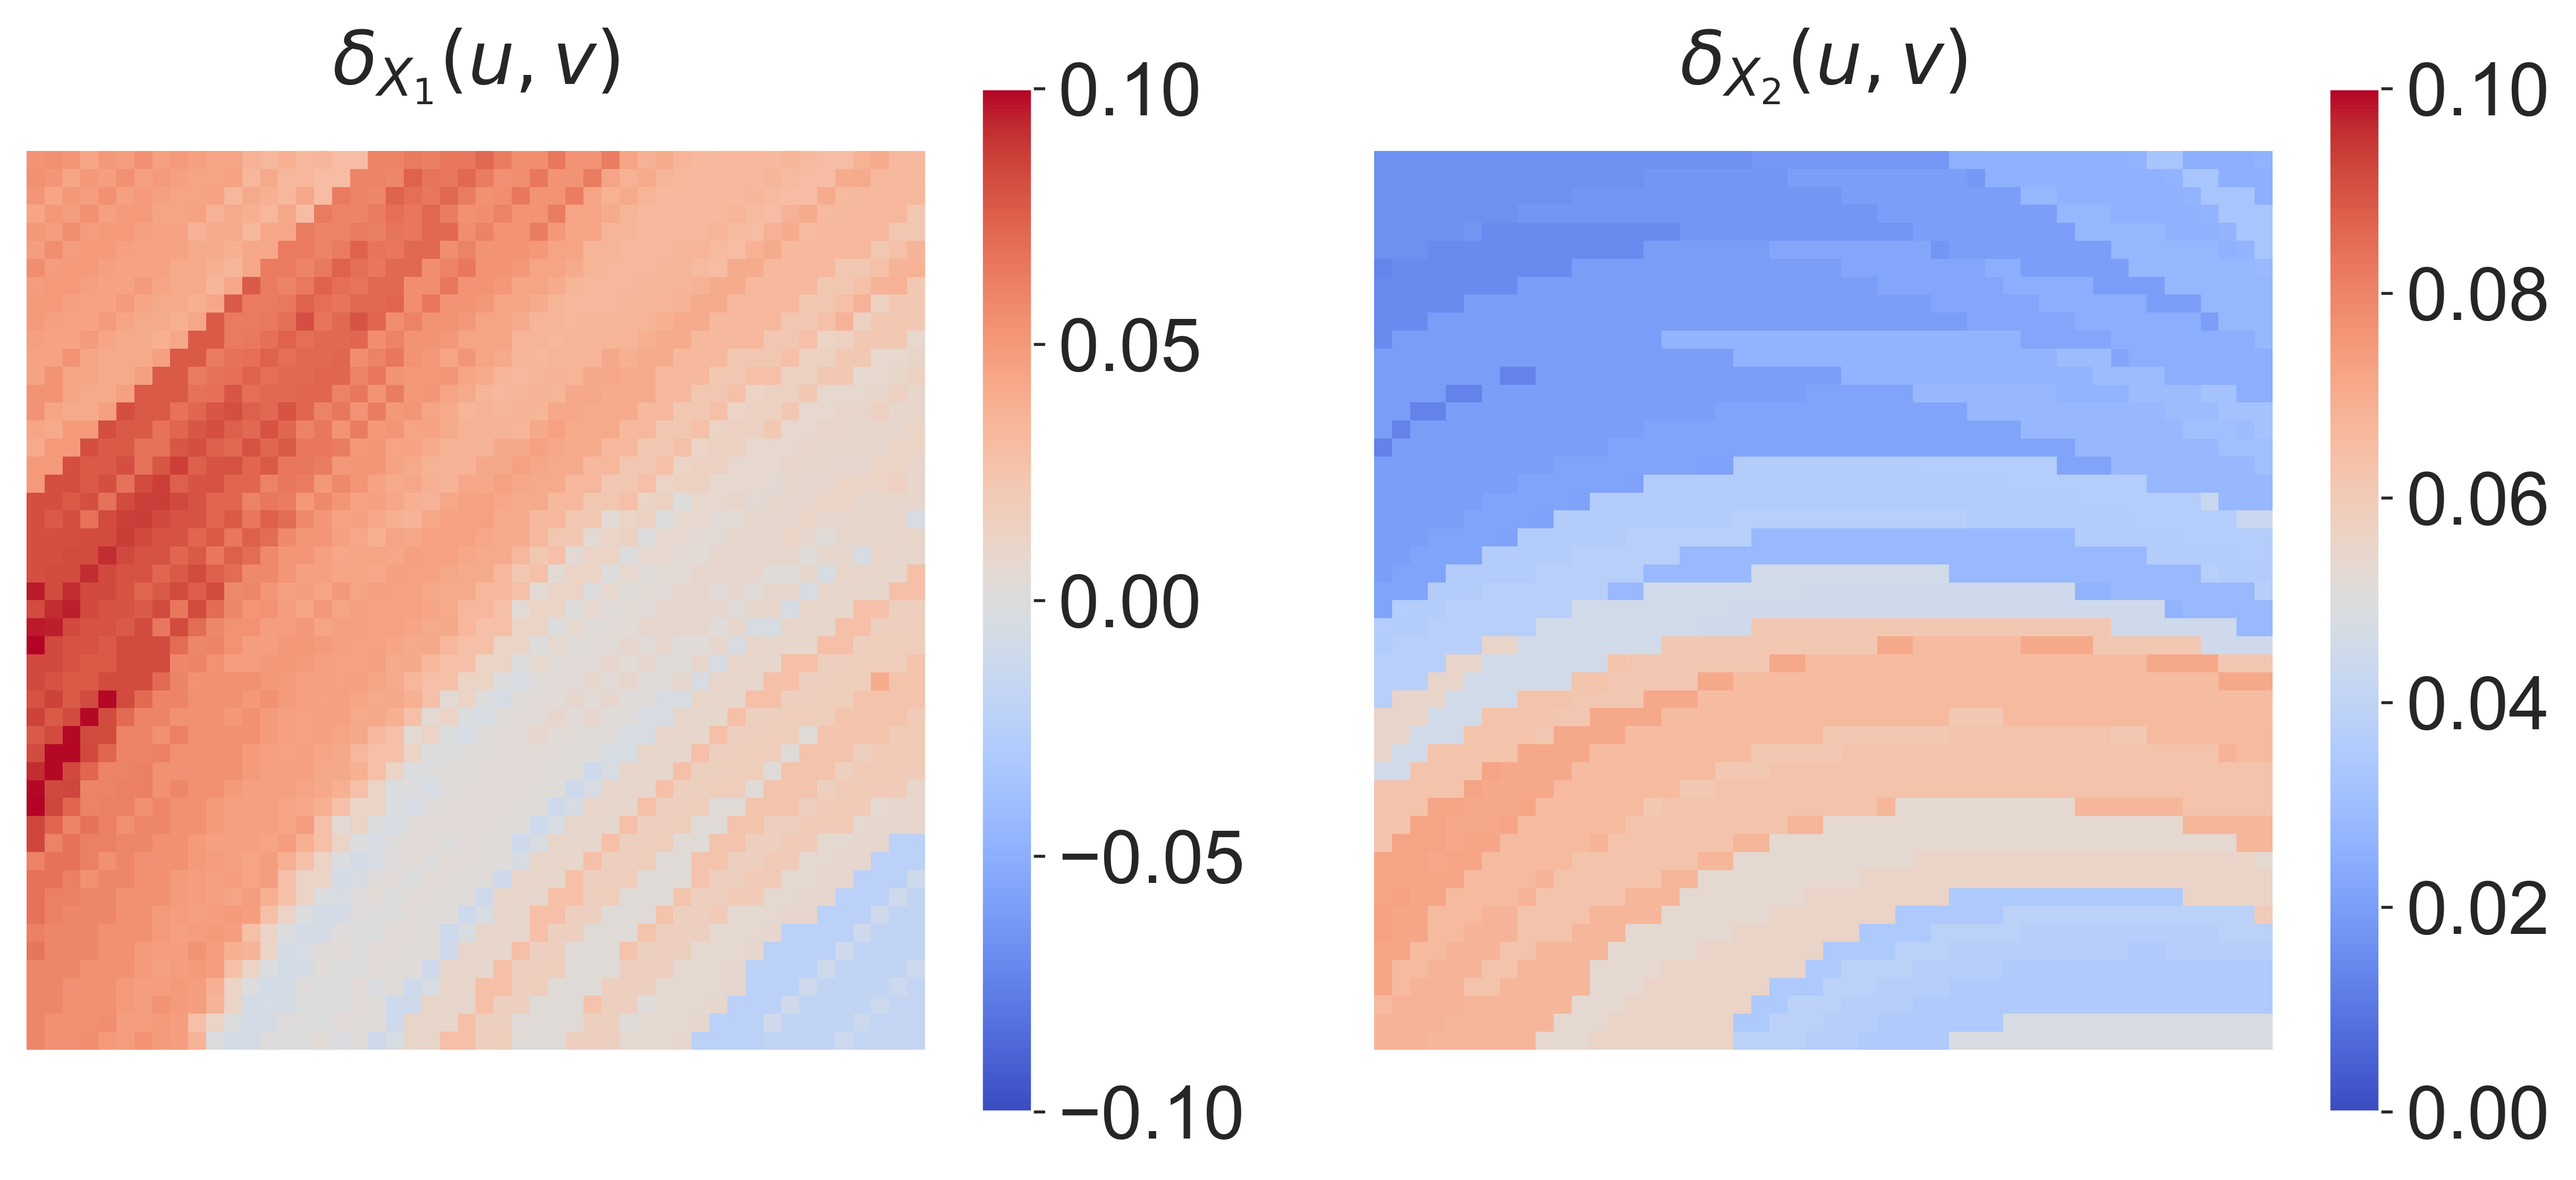

In [36]:
plot_s(geo_uncertainty_list, k=2, sub_titles=sub_titles_uncertainty, cmap='coolwarm',
       title='Uncertainty Delta - ConformalSHAPSmoothed + Noise',
       non_spatial=[], size=size)

In [37]:
X1_cover = (pred_results['X1_shap'] <= pred_results_coef_noise['X1_upper_bound']) & (
            pred_results['X1_shap'] >= pred_results_coef_noise['X1_lower_bound'])
X2_cover = (pred_results['X2_shap'] <= pred_results_coef_noise['X2_upper_bound']) & (
            pred_results['X2_shap'] >= pred_results_coef_noise['X2_lower_bound'])

In [38]:
b_cover = [X1_cover.values, X2_cover.values]

In [39]:
sub_titles = [r'$Cover_1$', r'$Cover_2$']

In [40]:
X2_cover.mean()

0.892